# 机器学习纳米学位毕业项目-猫狗大战

## 1 数据预处理
从 https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/ 下载训练数据到`data目录`

数据集中 `data/train/`里的猫狗图片没有分类，放在一个文件夹，需要将训练照片按照类别文件夹分类，猫和狗的图片放在不同的文件夹中。把数据按照4:1拆分成训练集和验证集合，train和valid 里面包含两个文件夹，一个是cat，一个是dog。

``` python 
├── data
│   ├── test [12500张]
│   ├── train [合计20000张]
│   │   ├── cat
│   │   └── dog
│   ├── valid [合计5000张]
│   │   ├── cat
│   │   └── dog
```

In [36]:
import os
import cv2
import seaborn as sns

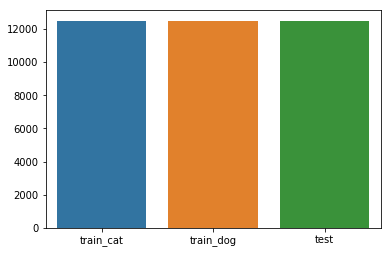

In [2]:
train_files = os.listdir('data/raw/train')
test_files = os.listdir('data/raw/test')
train_cat = [x for x in train_files if 'cat' in x]
train_dog = [x for x in train_files if 'dog' in x]

x = ['train_cat', 'train_dog', 'test']
y = [len(train_cat), len(train_dog), len(test_files)]
ax = sns.barplot(x=x, y=y)

In [3]:
print("训练数据集中：猫的数量：{}，狗的数量：{}；测试集图片数量：{}".format(len(train_cat),len(train_dog),len(test_files)))

训练数据集中：猫的数量：12500，狗的数量：12500；测试集图片数量：12500


In [39]:
from collections import defaultdict
img_size_dict = defaultdict(int)
for img_file in train_files:
    img = cv2.imread('data/raw/train/{}'.format(img_file))
    img_size = (img.shape[0], img.shape[1])
    img_size_dict[img_size] += 1

In [42]:
img_width_list = []
img_height_list = []
img_size_list = []
for w, h in img_size_dict.keys():
    img_width_list.append(w)
    img_height_list.append(h)
    img_size_list.append(img_size_dict[(w,h)])

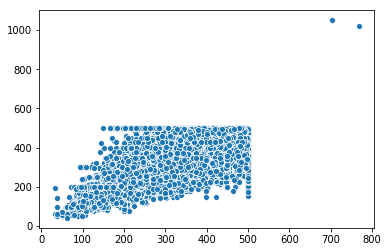

In [45]:
sns.scatterplot(img_width_list, img_height_list)

### 1.1 训练集和验证集拆分 4:1

In [4]:
from sklearn.model_selection import train_test_split
train_img_files, valid_img_files = train_test_split(train_files, test_size=0.2, random_state = 0)
print(len(train_img_files), len(valid_img_files))

20000 5000


10001 9999 2499 2501


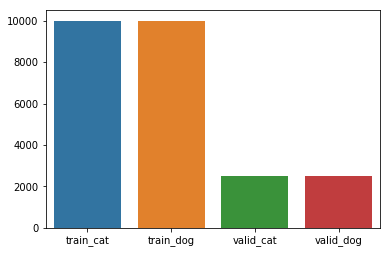

In [5]:
train_cat = [x for x in train_img_files if 'cat' in x]
train_dog = [x for x in train_img_files if 'dog' in x]
valid_cat = [x for x in valid_img_files if 'cat' in x]
valid_dog = [x for x in valid_img_files if 'dog' in x]
x = ['train_cat', 'train_dog', 'valid_cat', 'valid_dog']
y = [len(train_cat), len(train_dog), len(valid_cat), len(valid_dog)]
ax = sns.barplot(x=x, y=y)
print(len(train_cat), len(train_dog), len(valid_cat), len(valid_dog))

使用symlink文件描述符号的方式创建文件夹

In [6]:
import shutil
def remove_and_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)
    if dirname == 'data/test':
        pass
    else:
        os.mkdir(dirname+'/cat')
        os.mkdir(dirname+'/dog')

In [7]:
remove_and_mkdir('data/train')
remove_and_mkdir('data/valid')
remove_and_mkdir('data/test')

for filename in train_cat:
    os.symlink('../../raw/train/' + filename, 'data/train/cat/' + filename)
for filename in train_dog:
    os.symlink('../../raw/train/' + filename, 'data/train/dog/' + filename)
for filename in valid_cat:
    os.symlink('../../raw/train/' + filename, 'data/valid/cat/' + filename)
for filename in valid_dog:
    os.symlink('../../raw/train/' + filename, 'data/valid/dog/' + filename)
for filename in test_files:
    os.symlink('../raw/test/' + filename, 'data/test/' + filename)

### 1.2 图片预处理
- 按Xception模型的预处理方式归一化
- 将照片resized 到 299*299

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input
target_image_size = (299, 299)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=target_image_size,  # resize
        batch_size=16,
        class_mode='binary')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
        'data/valid', 
        target_size=target_image_size,  # resize
        batch_size=16,
        class_mode='binary')

Using TensorFlow backend.


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


打印一个batch的图片

Found 20000 images belonging to 2 classes.


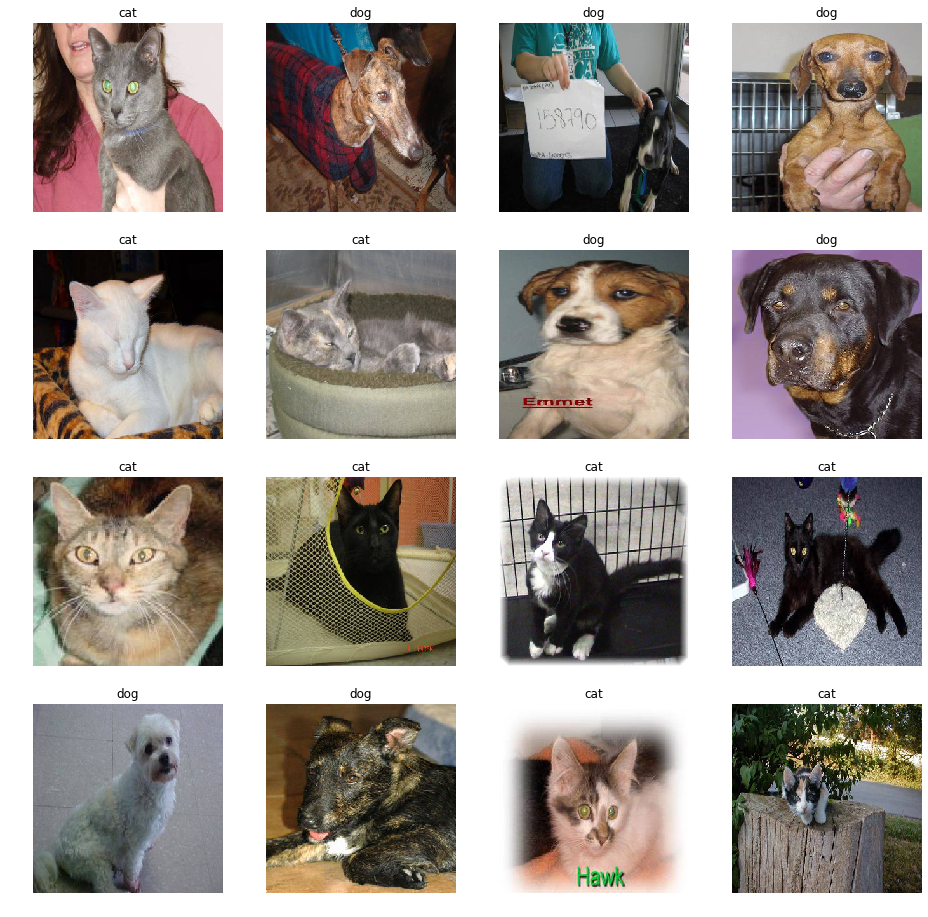

In [9]:
import matplotlib.pyplot as plt

sample_datagen = ImageDataGenerator(rescale=1/255.)
sample_generator = sample_datagen.flow_from_directory(
        'data/train',
        target_size=target_image_size,  # resize
        batch_size=16,
        class_mode='binary')

x, y = sample_generator.next()
plt.figure(figsize=(16, 16))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(4, 4, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img)

## 2 执行过程

### 2.1 构建神经网络

In [10]:
from keras.applications.resnet50 import ResNet50  
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.layers import Input
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, TensorBoard

In [11]:
def get_model_from_xception():
    base_model = Xception(input_tensor=Input((target_image_size[0], target_image_size[1], 3)), weights='imagenet', include_top=False)
    
    # 冻结base_model中所有的层
    for layers in base_model.layers:
        layers.trainable = False
   
    # 基于base_model定义模型
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(base_model.input, x)
    
    return model

In [46]:
def get_model_from_xception_2F():
    base_model = Xception(input_tensor=Input((target_image_size[0], target_image_size[1], 3)), weights='imagenet', include_top=False)
    
    # 冻结base_model中所有的层
    for layers in base_model.layers:
        layers.trainable = False
   
    # 基于base_model定义模型
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(base_model.input, x)
    
    return model

### 2.2 训练并选择模型

- steps_per_epoch = #training_examples // batch_size  
- nb_epoch=10
- validation_steps = #validation_examples // batch_size
- 选择binary_crossentropy作为loss function

In [12]:
def train(loss_name, epoch_count):
    model = get_model_from_xception()
    #print(model.summary())
    
    model_name = "xception_start"
    # 选择optimizer_name
    for optimizer_name in ['adam', 'adadelta', 'sgd']:
        model.compile(loss=loss_name, optimizer=optimizer_name, metrics=['accuracy'])
        best_model = ModelCheckpoint("{}_best_{}_{}.h5".format(model_name, loss_name, optimizer_name), monitor='val_acc', verbose=0, save_best_only=True)
        tensor_log = "./{}_best_{}_{}_tensor_log".format(model_name, loss_name,optimizer_name)
        model.fit_generator(
            train_generator,
            steps_per_epoch=(len(train_cat) + len(train_dog)) // 16,
            nb_epoch=epoch_count,
            validation_data=validation_generator,
            validation_steps=(len(valid_cat) + len(valid_dog)) // 16,
            callbacks=[best_model, TensorBoard(log_dir=tensor_log)])

In [13]:
train('binary_crossentropy', 10)

/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1250, validation_data=<keras_pre..., validation_steps=312, callbacks=[<keras.ca..., epochs=10)`


Epoch 1/10
1250/1250 [==============================] - 119s 95ms/step - loss: 0.1012 - acc: 0.9699 - val_loss: 0.0893 - val_acc: 0.9758
Epoch 2/10
1250/1250 [==============================] - 117s 94ms/step - loss: 0.0695 - acc: 0.9758 - val_loss: 0.0544 - val_acc: 0.9860
Epoch 3/10
1250/1250 [==============================] - 118s 94ms/step - loss: 0.0648 - acc: 0.9781 - val_loss: 0.0740 - val_acc: 0.9803
Epoch 4/10
1250/1250 [==============================] - 118s 94ms/step - loss: 0.0574 - acc: 0.9806 - val_loss: 0.0264 - val_acc: 0.9936
Epoch 5/10
1250/1250 [==============================] - 118s 94ms/step - loss: 0.0550 - acc: 0.9809 - val_loss: 0.0490 - val_acc: 0.9868
Epoch 6/10
1250/1250 [==============================] - 118s 94ms/step - loss: 0.0579 - acc: 0.9797 - val_loss: 0.0533 - val_acc: 0.9858
Epoch 7/10
1250/1250 [==============================] - 118s 94ms/step - loss: 0.0587 - acc: 0.9807 - val_loss: 0.0402 - val_acc: 0.9892
Epoch 8/10
1250/1250 [===================

/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1250, validation_data=<keras_pre..., validation_steps=312, callbacks=[<keras.ca..., epochs=10)`


Epoch 1/10
1250/1250 [==============================] - 118s 95ms/step - loss: 0.0502 - acc: 0.9833 - val_loss: 0.0757 - val_acc: 0.9775
Epoch 2/10
1250/1250 [==============================] - 117s 94ms/step - loss: 0.0491 - acc: 0.9831 - val_loss: 0.0396 - val_acc: 0.9878
Epoch 3/10
1250/1250 [==============================] - 117s 94ms/step - loss: 0.0506 - acc: 0.9830 - val_loss: 0.0425 - val_acc: 0.9876
Epoch 4/10
1250/1250 [==============================] - 117s 94ms/step - loss: 0.0536 - acc: 0.9823 - val_loss: 0.0585 - val_acc: 0.9827
Epoch 5/10
1250/1250 [==============================] - 117s 94ms/step - loss: 0.0548 - acc: 0.9805 - val_loss: 0.0613 - val_acc: 0.9813
Epoch 6/10
1250/1250 [==============================] - 117s 94ms/step - loss: 0.0503 - acc: 0.9834 - val_loss: 0.0385 - val_acc: 0.9880
Epoch 7/10
1250/1250 [==============================] - 117s 94ms/step - loss: 0.0468 - acc: 0.9843 - val_loss: 0.0423 - val_acc: 0.9876
Epoch 8/10
1250/1250 [===================

/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1250, validation_data=<keras_pre..., validation_steps=312, callbacks=[<keras.ca..., epochs=10)`


Epoch 1/10
1250/1250 [==============================] - 118s 94ms/step - loss: 0.0485 - acc: 0.9840 - val_loss: 0.0557 - val_acc: 0.9829
Epoch 2/10
1250/1250 [==============================] - 116s 93ms/step - loss: 0.0479 - acc: 0.9836 - val_loss: 0.0431 - val_acc: 0.9866
Epoch 3/10
1250/1250 [==============================] - 117s 93ms/step - loss: 0.0542 - acc: 0.9803 - val_loss: 0.0516 - val_acc: 0.9844
Epoch 4/10
1250/1250 [==============================] - 117s 94ms/step - loss: 0.0476 - acc: 0.9833 - val_loss: 0.0466 - val_acc: 0.9864
Epoch 5/10
1250/1250 [==============================] - 117s 94ms/step - loss: 0.0475 - acc: 0.9842 - val_loss: 0.0476 - val_acc: 0.9862
Epoch 6/10
1250/1250 [==============================] - 117s 93ms/step - loss: 0.0462 - acc: 0.9839 - val_loss: 0.0512 - val_acc: 0.9846
Epoch 7/10
1250/1250 [==============================] - 119s 95ms/step - loss: 0.0485 - acc: 0.9824 - val_loss: 0.0528 - val_acc: 0.9839
Epoch 8/10
1250/1250 [===================

In [47]:
def train_2F(loss_name, epoch_count):
    model = get_model_from_xception_2F()
    print(model.summary())
    
    model_name = "xception_start_2F"
    # 选择optimizer_name
    for optimizer_name in ['adam']:
        model.compile(loss=loss_name, optimizer=optimizer_name, metrics=['accuracy'])
        best_model = ModelCheckpoint("{}_best_{}_{}.h5".format(model_name, loss_name, optimizer_name), monitor='val_acc', verbose=0, save_best_only=True)
        tensor_log = "./{}_best_{}_{}_tensor_log".format(model_name, loss_name,optimizer_name)
        model.fit_generator(
            train_generator,
            steps_per_epoch=(len(train_cat) + len(train_dog)) // 16,
            nb_epoch=epoch_count,
            validation_data=validation_generator,
            validation_steps=(len(valid_cat) + len(valid_dog)) // 16,
            callbacks=[best_model, TensorBoard(log_dir=tensor_log)])

In [50]:
train_2F('binary_crossentropy', 10)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1250, validation_data=<keras_pre..., validation_steps=312, callbacks=[<keras.ca..., epochs=10)`


Epoch 1/10
1250/1250 [==============================] - 124s 100ms/step - loss: 0.0916 - acc: 0.9673 - val_loss: 0.0621 - val_acc: 0.9779
Epoch 2/10
1250/1250 [==============================] - 122s 98ms/step - loss: 0.0602 - acc: 0.9778 - val_loss: 0.0597 - val_acc: 0.9789
Epoch 3/10
1250/1250 [==============================] - 123s 98ms/step - loss: 0.0501 - acc: 0.9822 - val_loss: 0.0608 - val_acc: 0.9769
Epoch 4/10
1250/1250 [==============================] - 123s 98ms/step - loss: 0.0515 - acc: 0.9823 - val_loss: 0.0502 - val_acc: 0.9807
Epoch 5/10
1250/1250 [==============================] - 123s 98ms/step - loss: 0.0480 - acc: 0.9817 - val_loss: 0.0412 - val_acc: 0.9848
Epoch 6/10
1250/1250 [==============================] - 123s 98ms/step - loss: 0.0441 - acc: 0.9845 - val_loss: 0.0392 - val_acc: 0.9858
Epoch 7/10
1250/1250 [==============================] - 123s 98ms/step - loss: 0.0405 - acc: 0.9841 - val_loss: 0.0525 - val_acc: 0.9825
Epoch 8/10
1250/1250 [==================

### 2.3 使用模型进行预测

生成Kaggle文件

In [14]:
import pandas as pd
def generate_kaggle_file(pred_result, tag):
    df = pd.read_csv("sample_submission.csv")
    df["label"] = pred_result
    df.to_csv('submission_{}.csv'.format(tag), index=None)

读取照片进行预处理

In [15]:
def get_image(image_id):
    img = cv2.imread('data/test/{}.jpg'.format(image_id))
    img = cv2.resize(img, target_image_size)
    img.astype(np.float32)
    return img
test_count = 12500

In [16]:
from tqdm import *
import numpy as np
import cv2

image_matrix = np.zeros((test_count,target_image_size[0], target_image_size[0], 3), dtype=np.float32)
for i in tqdm(range(test_count)):
    image_matrix[i] = get_image(i+1)
image_matrix = preprocess_input(image_matrix)

100%|██████████| 12500/12500 [00:26<00:00, 463.62it/s]


In [23]:
model = get_model_from_xception()
for optimizer_name in ['adam', 'adadelta', 'sgd']:
    weights_name = 'xception_start_best_binary_crossentropy_{}.h5'.format(optimizer_name)
    model.load_weights(weights_name)
    pred = model.predict(image_matrix, verbose=1)
    pred = pred.clip(min=0.005, max=0.995)
    generate_kaggle_file(pred, "xception_start_{}".format(optimizer_name))

12500/12500 [==============================] - 61s 5ms/step


In [51]:
model = get_model_from_xception_2F()
for optimizer_name in ['adam']:
    weights_name = 'xception_start_2F_best_binary_crossentropy_{}.h5'.format(optimizer_name)
    model.load_weights(weights_name)
    pred = model.predict(image_matrix, verbose=1)
    pred = pred.clip(min=0.005, max=0.995)
    generate_kaggle_file(pred, "xception_start_2F_{}".format(optimizer_name))

12500/12500 [==============================] - 60s 5ms/step


**Kaggle结果分数**

| 优化器 | 分数 |
| --- | --- |
|adadelta| 0.08204 |
|adam| 0.06186 |
|sgd| 0.09087 |

### 2.4 随机挑选照片查看预测效果

In [24]:
weights_name = 'xception_start_best_binary_crossentropy_adam.h5'
model.load_weights(weights_name)

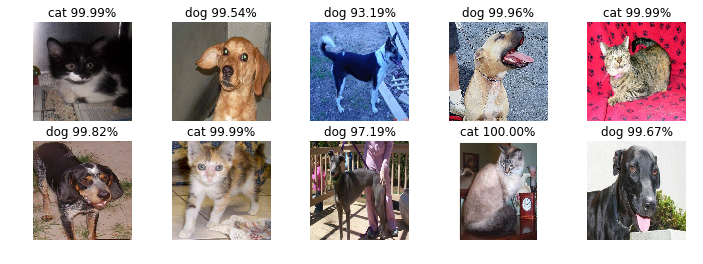

In [25]:
import random
plt.figure(figsize=(12, 4))
for i in range(10):
    x = get_image(random.randint(1, test_count))
    prediction = model.predict(preprocess_input(np.expand_dims(x, axis=0)))
    prediction = prediction[0]
    plt.subplot(2, 5, i+1)
    if prediction < 0.5:
        plt.title("cat {:.2f}%".format(100 - float(prediction)*100))
    else:
        plt.title("dog {:.2f}%".format(float(prediction)*100))
    
    plt.axis('off')
    plt.imshow(x[:, :, ::-1]) 

## 3 完善

冻结Xception模型BN层

参考文章https://zhuanlan.zhihu.com/p/56225304

In [26]:
import keras.backend as K
K.set_learning_phase(0)

使用adam优化算法，分别使用dropout为0, 0.1, 0.2, 0.3进行训练

In [27]:
def get_model(base_model_name, dropout_list):
    # 选择base_model
    if base_model_name == "resnet50":
        base_model = ResNet50(input_tensor=Input((target_image_size[0], target_image_size[1], 3)), weights='imagenet', include_top=False)
    elif base_model_name == "inceptionv3":
        base_model = InceptionV3(input_tensor=Input((target_image_size[0], target_image_size[1], 3)), weights='imagenet', include_top=False)
    elif base_model_name == "xception":
        base_model = Xception(input_tensor=Input((target_image_size[0], target_image_size[1], 3)), weights='imagenet', include_top=False)
    elif base_model_name == "inception_resnet_v2":
        base_model = InceptionResNetV2(input_tensor=Input((target_image_size[0], target_image_size[1], 3)), weights='imagenet', include_top=False)
    
    # 冻结base_model中所有的层
    for layers in base_model.layers:
        layers.trainable = False
    
    model_list = []
    for dropout in dropout_list:
        # 基于base_model定义模型
        x = GlobalAveragePooling2D()(base_model.output)
        if dropout > 1e-6:
            x = Dropout(dropout)(x)
        x = Dense(1, activation='sigmoid')(x)
        model = Model(base_model.input, x)
        model_list.append((model, "{}_dropout-{:.2f}".format(base_model_name, dropout)))
    
    return model_list

In [29]:
def train_model(base_model_name, loss_name, optimizer_name, epoch_count, dropout_list):
    model_list = get_model(base_model_name, dropout_list)
    
    # 训练
    for model, model_name in model_list:
        #print(model.summary())
        model.compile(loss=loss_name, optimizer=optimizer_name, metrics=['accuracy'])
        best_model = ModelCheckpoint("{}_best_{}_{}.h5".format(model_name, loss_name, optimizer_name), monitor='val_acc', verbose=0, save_best_only=True)
        tensor_log = "./{}_best_{}_{}_tensor_log".format(model_name, loss_name,optimizer_name)
        model.fit_generator(
            train_generator,
            steps_per_epoch=(len(train_cat) + len(train_dog)) // 16,
            nb_epoch=epoch_count,
            validation_data=validation_generator,
            validation_steps=(len(valid_cat) + len(valid_dog)) // 16,
            callbacks=[best_model, TensorBoard(log_dir=tensor_log)])
    

In [30]:
# dropout=[0, 0.1, 0.2, 0.3]
train_model("xception", "binary_crossentropy", "adam", 10, [0, 0.1, 0.2, 0.3])

/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1250, validation_data=<keras_pre..., validation_steps=312, callbacks=[<keras.ca..., epochs=10)`
  app.launch_new_instance()


Epoch 1/10
1250/1250 [==============================] - 108s 86ms/step - loss: 0.0473 - acc: 0.9894 - val_loss: 0.0204 - val_acc: 0.9946
Epoch 2/10
1250/1250 [==============================] - 108s 86ms/step - loss: 0.0196 - acc: 0.9941 - val_loss: 0.0145 - val_acc: 0.9950
Epoch 3/10
1250/1250 [==============================] - 108s 86ms/step - loss: 0.0168 - acc: 0.9946 - val_loss: 0.0157 - val_acc: 0.9952
Epoch 4/10
1250/1250 [==============================] - 108s 86ms/step - loss: 0.0149 - acc: 0.9955 - val_loss: 0.0152 - val_acc: 0.9950
Epoch 5/10
1250/1250 [==============================] - 108s 87ms/step - loss: 0.0132 - acc: 0.9960 - val_loss: 0.0144 - val_acc: 0.9954
Epoch 6/10
1250/1250 [==============================] - 108s 86ms/step - loss: 0.0118 - acc: 0.9965 - val_loss: 0.0145 - val_acc: 0.9950
Epoch 7/10
1250/1250 [==============================] - 108s 87ms/step - loss: 0.0102 - acc: 0.9968 - val_loss: 0.0150 - val_acc: 0.9954
Epoch 8/10
1250/1250 [===================

/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1250, validation_data=<keras_pre..., validation_steps=312, callbacks=[<keras.ca..., epochs=10)`
  app.launch_new_instance()


Epoch 1/10
1250/1250 [==============================] - 110s 88ms/step - loss: 0.0450 - acc: 0.9910 - val_loss: 0.0192 - val_acc: 0.9952
Epoch 2/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.0193 - acc: 0.9939 - val_loss: 0.0159 - val_acc: 0.9954
Epoch 3/10
1250/1250 [==============================] - 108s 87ms/step - loss: 0.0172 - acc: 0.9949 - val_loss: 0.0167 - val_acc: 0.9940
Epoch 4/10
1250/1250 [==============================] - 108s 87ms/step - loss: 0.0149 - acc: 0.9949 - val_loss: 0.0148 - val_acc: 0.9950
Epoch 5/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.0128 - acc: 0.9962 - val_loss: 0.0149 - val_acc: 0.9950
Epoch 6/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.0117 - acc: 0.9960 - val_loss: 0.0154 - val_acc: 0.9950
Epoch 7/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.0102 - acc: 0.9970 - val_loss: 0.0154 - val_acc: 0.9946
Epoch 8/10
1250/1250 [===================

/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1250, validation_data=<keras_pre..., validation_steps=312, callbacks=[<keras.ca..., epochs=10)`
  app.launch_new_instance()


Epoch 1/10
1250/1250 [==============================] - 109s 88ms/step - loss: 0.0462 - acc: 0.9904 - val_loss: 0.0198 - val_acc: 0.9940
Epoch 2/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.0196 - acc: 0.9943 - val_loss: 0.0169 - val_acc: 0.9948
Epoch 3/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.0170 - acc: 0.9943 - val_loss: 0.0151 - val_acc: 0.9956
Epoch 4/10
1250/1250 [==============================] - 108s 87ms/step - loss: 0.0147 - acc: 0.9956 - val_loss: 0.0155 - val_acc: 0.9950
Epoch 5/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.0126 - acc: 0.9961 - val_loss: 0.0158 - val_acc: 0.9946
Epoch 6/10
1250/1250 [==============================] - 108s 86ms/step - loss: 0.0117 - acc: 0.9962 - val_loss: 0.0170 - val_acc: 0.9948
Epoch 7/10
1250/1250 [==============================] - 108s 87ms/step - loss: 0.0111 - acc: 0.9966 - val_loss: 0.0211 - val_acc: 0.9934
Epoch 8/10
1250/1250 [===================

/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/mnt/ssd01/anaconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1250, validation_data=<keras_pre..., validation_steps=312, callbacks=[<keras.ca..., epochs=10)`
  app.launch_new_instance()


Epoch 1/10
1250/1250 [==============================] - 110s 88ms/step - loss: 0.0480 - acc: 0.9891 - val_loss: 0.0195 - val_acc: 0.9942
Epoch 2/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.0192 - acc: 0.9940 - val_loss: 0.0163 - val_acc: 0.9946
Epoch 3/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.0166 - acc: 0.9948 - val_loss: 0.0155 - val_acc: 0.9950
Epoch 4/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.0143 - acc: 0.9952 - val_loss: 0.0141 - val_acc: 0.9956
Epoch 5/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.0129 - acc: 0.9960 - val_loss: 0.0146 - val_acc: 0.9948
Epoch 6/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.0119 - acc: 0.9963 - val_loss: 0.0144 - val_acc: 0.9956
Epoch 7/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.0103 - acc: 0.9966 - val_loss: 0.0150 - val_acc: 0.9946
Epoch 8/10
1250/1250 [===================

生成Kaggle文件

In [31]:
model_list = get_model("xception", [0, 0.1, 0.2, 0.3])

In [32]:
for (model, model_name) in model_list:
    weights_name = '{}_best_binary_crossentropy_adam.h5'.format(model_name)
    model.load_weights(weights_name)
    pred = model.predict(image_matrix, verbose=1)
    pred = pred.clip(min=0.005, max=0.995)
    generate_kaggle_file(pred, model_name)

12500/12500 [==============================] - 53s 4ms/step


**Kaggle结果分数**

| dropout | 分数 |
| --- | --- |
|no| 0.04552 |
|0.1| 0.04375 |
|0.2| 0.04459 |
|0.3| 0.04520 |

随机挑选图片预测结果

In [33]:
model = get_model("xception", [0.1])[0][0]
model.load_weights("xception_dropout-0.10_best_binary_crossentropy_adam.h5")

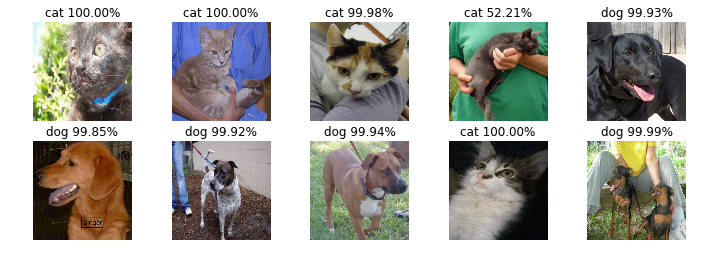

In [35]:
import random
plt.figure(figsize=(12, 4))
for i in range(10):
    x = get_image(random.randint(1, test_count))
    prediction = model.predict(preprocess_input(np.expand_dims(x, axis=0)))
    prediction = prediction[0]
    plt.subplot(2, 5, i+1)
    if prediction < 0.5:
        plt.title("cat {:.2f}%".format(100 - float(prediction)*100))
    else:
        plt.title("dog {:.2f}%".format(float(prediction)*100))
    
    plt.axis('off')
    plt.imshow(x[:, :, ::-1]) 